<a href="https://colab.research.google.com/github/FrancisBacon95/Classification-of-ECG-signals/blob/master/Classification_of_ECG_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Preprocessing

## 1-1. hyper-parameter 정의

In [3]:
path="./gdrive/My Drive/Colab Notebooks/mitbih_database"
window_size=160
maximum_counting=10000

classes=['N','L','R','A','V','/']
n_classes=len(classes)
count_classes=[0]*n_classes
X,Y=[],[]

In [15]:
filenames= os.listdir(path)
records,annotations=[],[]
for f in filenames:
    if f.split('.')[1]=='txt':
        annotations.append(path+"/"+f)
    if f.split('.')[1]=="csv":
        records.append(path+"/"+f)

## 1-2. beat 정의 및 X, Y 초기화

In [17]:
for i in range(len(records)):
    record=pd.read_csv(records[i],index_col=0)
    signals=[]
    try:
        signals.extend(record.loc[:,"'MLII'"].to_list())
    except:
        #메인 리드가 MLII가 아닌 것은 제외한다.
        print(records[i].split('/')[-1]+" 메인 리드 :",end=" ")
        print(record.columns[0])
        continue

    beat=[]

    annotation=open(annotations[i],'r')
    lines=annotation.readlines()
    for line in lines[1:]: #lines의 0은 Header
        tmp=line.split(' ')
        tmp=filter(None, tmp)
        next(tmp)
        pos=int(next(tmp))
        arrhythmia_type=next(tmp)
        if(arrhythmia_type in classes):
            arrhythmia_index=classes.index(arrhythmia_type)
            if count_classes[arrhythmia_index]> maximum_counting:
                continue
            else:
                count_classes[arrhythmia_index]+=1
                if(window_size<pos and pos<(len(signals)-window_size)): 
                    beat=signals[pos-window_size+1:pos+window_size] #beat size
                    X.append(beat)
                    Y.append(arrhythmia_index)

102.csv 메인 리드 : 'V5'
104.csv 메인 리드 : 'V5'


## 1-3. Data shape

(41738, 319) (41738,)
N
V
A
R
/
L


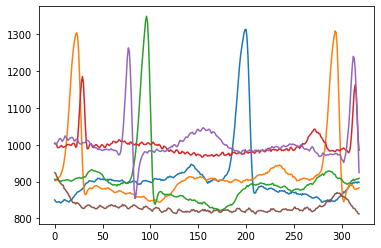

In [18]:
print(np.shape(X),np.shape(Y))

tmp=[]
for i in range(len(X)):
    if Y[i] not in tmp:
        tmp.append(Y[i])
        plt.plot(X[i])
        print(classes[Y[i]])

In [19]:
# X 배열 끝에 Y값 삽입
for i in range(len(X)):
    X[i].append(Y[i])

In [20]:
X_train_df = pd.DataFrame(X)
#각각의 beat type의 count
per_class=X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class) #V5 포함했을 때와 비교했을 때 '5'의 카운트가 크게 차이남

0    9993
1    8071
2    7255
4    7065
5    7023
3    2331
Name: 319, dtype: int64


## 1-4. Resampling

(확인 필요)

### 5000 이상 : 중복 X   // 5000 이하 : 중복 O

In [21]:
from sklearn.utils import resample
resampled_X_train_df=pd.DataFrame()
for name, group in X_train_df.groupby(X_train_df[X_train_df.shape[1]-1]):
    if len(group)>5000:
        tmp=resample(group,replace=False,n_samples=5000, random_state=880818)
    else:
        tmp=resample(group,replace=True, n_samples=5000, random_state=880818)
    print(len(tmp))
    resampled_X_train_df=pd.concat([resampled_X_train_df,tmp])
print(len(resampled_X_train_df))
resampled_X_train_df

5000
5000
5000
5000
5000
5000
30000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319
5176,986,987,988,991,989,987,984,982,981,984,985,986,988,988,989,992,992,993,995,990,987,986,988,993,995,996,995,997,996,998,996,994,987,983,986,988,989,989,989,990,...,987,985,982,983,983,984,983,981,982,984,984,987,989,987,984,982,981,982,981,982,983,984,989,990,991,990,985,986,984,982,982,984,984,985,987,990,988,988,987,0
3685,967,968,966,965,965,963,967,967,969,965,962,963,967,969,966,966,966,969,973,977,980,980,979,980,979,982,982,980,980,980,982,984,980,979,977,978,978,976,975,973,...,991,992,991,991,995,996,996,995,995,995,994,994,997,999,998,999,997,1000,1000,1002,1001,998,999,997,1000,999,999,998,999,1001,1001,1004,1002,1003,1000,1000,1001,1005,1005,0
13447,1032,1026,1025,1025,1023,1027,1028,1025,1024,1021,1019,1020,1021,1018,1018,1011,1011,1011,1010,1006,1000,997,998,996,996,998,994,993,992,992,999,995,994,990,990,990,996,991,991,990,...,991,993,996,996,995,992,992,994,999,999,997,995,994,997,996,992,989,989,988,990,996,992,992,989,989,991,996,998,997,996,995,995,998,997,994,991,992,994,999,0
13321,948,951,952,948,949,947,951,953,954,951,950,947,946,952,953,952,949,949,952,958,954,953,953,954,952,958,959,959,957,955,954,956,957,959,957,955,957,960,961,959,...,984,985,985,985,982,978,977,975,979,982,982,979,979,976,975,978,975,971,969,972,970,973,973,971,968,969,971,974,973,970,968,970,974,977,975,973,968,970,973,0
4477,957,954,955,952,952,952,950,951,952,952,951,949,947,951,960,974,993,1021,1058,1104,1160,1221,1274,1308,1318,1297,1250,1188,1118,1051,998,964,946,940,940,948,955,955,954,949,...,968,962,961,956,952,952,953,953,955,954,955,953,953,950,948,951,951,950,951,952,955,957,958,958,955,956,952,954,955,956,956,959,960,960,963,962,961,958,959,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20286,1011,1010,1013,1014,1015,1014,1014,1011,1010,1006,1004,1003,1001,1000,1001,1001,1001,1001,1000,997,996,992,989,989,989,988,987,989,990,991,989,989,988,986,987,984,987,988,992,994,...,1010,1015,1013,1009,1011,1010,1008,1009,1009,1011,1013,1013,1014,1015,1013,1012,1011,1009,1009,1006,1009,1013,1016,1018,1019,1022,1022,1018,1014,1010,1008,1007,1008,1003,1003,1007,1009,1010,1013,5
20806,878,880,880,881,882,881,881,879,877,878,878,879,878,882,885,884,883,881,880,881,880,879,878,878,880,883,883,884,886,883,884,880,880,881,881,881,881,885,884,885,...,808,807,805,803,798,797,796,794,793,792,794,793,793,792,791,789,787,786,789,788,790,791,793,794,795,794,796,797,798,798,799,800,801,807,810,813,814,816,818,5
27478,954,952,947,947,946,947,947,944,943,942,945,943,936,930,927,930,929,926,926,924,923,922,923,926,925,922,919,921,922,925,927,926,923,924,925,925,924,916,908,904,...,925,927,925,924,920,918,919,920,923,925,920,925,927,927,923,917,914,919,921,927,929,928,922,922,922,922,924,924,922,920,920,925,926,925,927,926,926,928,927,5
27670,957,951,951,954,954,953,947,950,947,950,953,950,949,945,946,947,949,949,948,947,945,946,949,949,946,945,942,944,947,949,945,947,945,946,947,946,947,945,945,946,...,965,964,964,964,963,966,968,969,971,971,969,973,975,975,975,975,974,975,979,982,981,983,989,996,999,999,994,988,985,988,988,985,983,982,981,983,983,981,979,5


# 2. Modeling

## 2-1. Set 분할

In [22]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [23]:
train, test=train_test_split(resampled_X_train_df,test_size=0.30)
print("X_train : ",len(train))
print("X_test : ",len(test))

X_train :  21000
X_test :  9000


In [24]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
print("Y shape :",np.shape(y_train),np.shape(y_test))

x_train=train.iloc[:,:train.shape[1]-1].values
x_test=test.iloc[:,:test.shape[1]-1].values
x_train=x_train.reshape(len(x_train),x_train.shape[1],1)
x_test=x_test.reshape(len(x_test),x_test.shape[1],1)
print("X shape :",np.shape(x_train),np.shape(x_test))

Y shape : (21000, 6) (9000, 6)
X shape : (21000, 319, 1) (9000, 319, 1)


## 2-2. modeling 첫 시도

In [25]:
from keras.layers import Input, Convolution1D, MaxPool1D, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix

In [26]:
def network(x_train,y_train,x_test,y_test):
    im_shape=(x_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape),name='inputs_cnn')
    #conv. layer 1
    conv1_1=Convolution1D(64,(6),activation="elu",input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    #pooling layer 1
    pool1=MaxPool1D(pool_size=(3),strides=(2),padding="same")(conv1_1)
    #conv. layer 2
    conv2_1=Convolution1D(128,(3),activation="elu",input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    #conv. layer 3
    conv3_1=Convolution1D(128,(3),activation="elu",input_shape=im_shape)(conv2_1)
    conv3_1=BatchNormalization()(conv3_1)
    #pooling layer 2
    pool2=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv3_1)
    #conv. layer 4
    conv4_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(pool2)
    conv4_1=BatchNormalization()(conv4_1)
    #conv. layer 5
    conv5_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv4_1)
    conv5_1=BatchNormalization()(conv5_1)
    #pooling layer 3
    pool3=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv5_1)
    #flattened layer 1
    flatten=Flatten()(pool3)
    #dense layers
    dense_end1=Dense(1024,activation='elu')(flatten)
    
    #output layers
    main_output=Dense(6,activation='softmax',name='main_output')(dense_end1)
    
    model=Model(inputs=inputs_cnn,outputs=main_output)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    callbacks=[EarlyStopping(monitor='val_loss',patience=8),
              ModelCheckpoint(filepath='best_model.h5',monitor='val_loss',save_best_only=True)]
    
    history=model.fit(x_train, y_train, epochs=2, callbacks=callbacks, batch_size=32,validation_data=(x_test,y_test))
    model.load_weights('best_model.h5')
    return (model, history)

In [27]:
model, history=network(x_train,y_train,x_test,y_test)

Epoch 1/2
657/657 [==============================] - 228s 347ms/step - loss: 1.7981 - accuracy: 0.5159 - val_loss: 9.1290 - val_accuracy: 0.2047
Epoch 2/2
657/657 [==============================] - 221s 337ms/step - loss: 0.8294 - accuracy: 0.7220 - val_loss: 7.8055 - val_accuracy: 0.2757


In [28]:
scores=model.evaluate((x_test),y_test,verbose=0)
print("Accuracy:",scores[1]*100)

Accuracy: 27.566665410995483


###  Confusion Matrix

In [32]:
y_pred=model.predict(x_test)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cnf_matrix)

[[951   0 232   3 219  62]
 [550  46 203  27 557 102]
 [616   0 710  10 136  22]
 [904   0 443   7 160  17]
 [685   1 321  21 464  26]
 [609   1 368   4 220 303]]


In [33]:
import itertools

def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

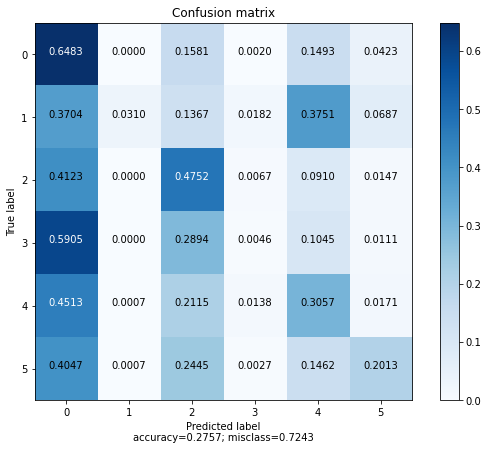

In [34]:
plot_confusion_matrix(cnf_matrix, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix')

# 3. Modeling 두번째 시도

In [36]:
path="./gdrive/My Drive/Colab Notebooks/mitbih_database"

classes=['N','L','R','A','V','/']
n_classes=len(classes)
count_classes=[0]*n_classes
X,Y=[],[]

In [43]:
filenames= os.listdir(path)
records,annotations=[],[]
for f in filenames:
    if f.split('.')[1]=='txt':
        annotations.append(path+"/"+f)
    if f.split('.')[1]=='csv':
        records.append(path+"/"+f)

['./gdrive/My Drive/Colab Notebooks/mitbih_database/108annotations.txt',
 './gdrive/My Drive/Colab Notebooks/mitbih_database/232annotations.txt',
 './gdrive/My Drive/Colab Notebooks/mitbih_database/115annotations.txt',
 './gdrive/My Drive/Colab Notebooks/mitbih_database/100annotations.txt',
 './gdrive/My Drive/Colab Notebooks/mitbih_database/228annotations.txt',
 './gdrive/My Drive/Colab Notebooks/mitbih_database/107annotations.txt',
 './gdrive/My Drive/Colab Notebooks/mitbih_database/220annotations.txt',
 './gdrive/My Drive/Colab Notebooks/mitbih_database/112annotations.txt',
 './gdrive/My Drive/Colab Notebooks/mitbih_database/113annotations.txt',
 './gdrive/My Drive/Colab Notebooks/mitbih_database/234annotations.txt',
 './gdrive/My Drive/Colab Notebooks/mitbih_database/221annotations.txt',
 './gdrive/My Drive/Colab Notebooks/mitbih_database/106annotations.txt',
 './gdrive/My Drive/Colab Notebooks/mitbih_database/233annotations.txt',
 './gdrive/My Drive/Colab Notebooks/mitbih_database

## 3-1. beat 정의 및 X, Y 초기화

#### set(사람)별로 편차가 큼
200번대 환자들은 유독 차이 큼

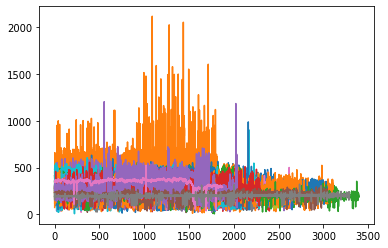

In [46]:
import matplotlib.pyplot as plt

avg_list=[]
for i in range(len(annotations)):
    annotation=open(annotations[i],'r')
    lines=annotation.readlines()
    a_list=[]
    for i in range(3,len(lines)):
        now=list(filter(None,lines[i].split(" ")))[1]
        before=list(filter(None,lines[i-1].split(" ")))[1]
        a_list.append(int(now)-int(before))

    plt.plot(range(0,len(a_list)),a_list)

    a_array=np.array(a_list)
    avg=np.mean(a_array)
    avg_list.append(avg)

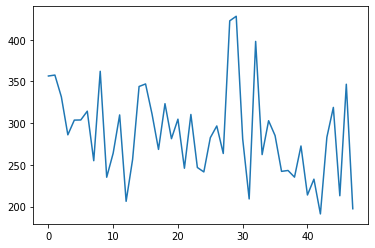

In [47]:
plt.plot(range(0,len(avg_list)),avg_list)

In [48]:
for i in range(len(records)):
    record=pd.read_csv(records[i],index_col=0)
    signals=[]
    try:
        signals.extend(record.loc[:,"'MLII'"].to_list())
    except:
        #메인 리드가 MLII가 아닌 것은 제외한다.
        print(records[i].split('/')[-1]+" 메인 리드 :",end=" ")
        print(record.columns[0])
        continue

    beat=[]
    a=[]
    annotation=open(annotations[i],'r')
    lines=annotation.readlines()
    for j in range(3,len(lines)): # 1번 ~ 2번: 시작 지점이라 이상함
        now_tmp=list(filter(None,lines[j].split(" ")))
        before_tmp=list(filter(None,lines[j-1].split(" ")))
        now_num_sample=int(now_tmp[1])
        before_num_sample=int(before_tmp[1])
        beat_type=now_tmp[2]
        if (beat_type in classes):
            beat_idx=classes.index(beat_type)
            if count_classes[beat_idx] > maximum_counting: #################확인 필요#####################
                continue
            else:
                count_classes[beat_idx]+=1
                beat=signals[before_num_sample:now_num_sample]
                X.append(beat)
                if len(signals[before_num_sample:now_num_sample])>1000:
                    print("심박 1000 이상 찍힘 : ",annotations[i])
                Y.append(beat_idx)

심박 1000 이상 찍힘 :  ./gdrive/My Drive/Colab Notebooks/mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./gdrive/My Drive/Colab Notebooks/mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./gdrive/My Drive/Colab Notebooks/mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./gdrive/My Drive/Colab Notebooks/mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./gdrive/My Drive/Colab Notebooks/mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./gdrive/My Drive/Colab Notebooks/mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./gdrive/My Drive/Colab Notebooks/mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./gdrive/My Drive/Colab Notebooks/mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./gdrive/My Drive/Colab Notebooks/mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./gdrive/My Drive/Colab Notebooks/mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./gdrive/My Drive/Colab Notebooks/mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./gdrive/My Drive/Colab Notebooks/mit

In [49]:
print(len(X))
print(len(Y))

41745
41745


#### 각각의 비트마다 포함된 포인트 수가 차이 남

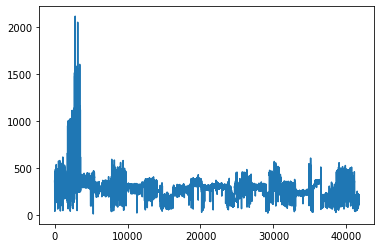

In [50]:
X_len=[len(x) for x in X]
plt.plot(range(0,len(X_len)),X_len)

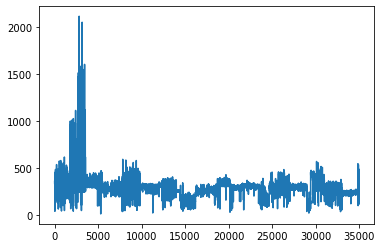

In [51]:
plt.plot(range(0,len(X_len[:35000])),X_len[:35000])

## 3-2. Data shape

#### 한 비트당 포인트 수를 같게 만들어 줌

In [52]:
maximum=max([len(x) for x in X])
for x in X:
    if len(x) < maximum:
        x.extend([0]*(maximum-len(x)))

(41745, 2114) (41745,)
N
V
A
R
/
L
(41745, 2114)


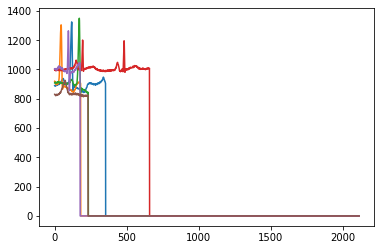

In [53]:
print(np.shape(X),np.shape(Y))

tmp=[]
for i in range(len(X)):
    if Y[i] not in tmp:
        tmp.append(Y[i])
        plt.plot(X[i])
        print(classes[Y[i]])
print(np.shape(X))

In [54]:
# X 배열 끝에 Y값 삽입
for i in range(len(X)):
    X[i].append(Y[i])

In [55]:
X_train_df = pd.DataFrame(X)
#각각의 beat type의 count
per_class=X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class) #V5 포함했을 때와 비교했을 때 '5'의 카운트가 크게 차이남

0    10001
1     8072
2     7253
4     7064
5     7024
3     2331
Name: 2114, dtype: int64


## 1-4. Resampling

(확인 필요)

### 5000 이상 : 중복 X   // 5000 이하 : 중복 O

In [56]:
from sklearn.utils import resample
resampled_X_train_df=pd.DataFrame()
for name, group in X_train_df.groupby(X_train_df[X_train_df.shape[1]-1]):
    if len(group)>5000:
        tmp=resample(group,replace=False,n_samples=5000, random_state=880818)
    else:
        tmp=resample(group,replace=True, n_samples=5000, random_state=880818)
    print(len(tmp))
    resampled_X_train_df=pd.concat([resampled_X_train_df,tmp])
print(len(resampled_X_train_df))
resampled_X_train_df

5000
5000
5000
5000
5000
5000
30000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2113,2114
6427,928,928,929,926,927,923,922,923,923,926,927,929,927,925,924,922,919,915,916,916,916,917,918,918,916,914,913,912,909,905,907,904,903,905,906,907,907,904,903,902,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12705,976,972,966,966,968,971,973,970,965,967,965,969,968,966,967,969,969,971,971,971,965,969,968,973,975,973,973,971,973,974,976,974,972,970,970,975,978,976,974,972,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7067,935,936,937,933,932,933,931,931,930,929,929,928,934,937,936,937,937,936,939,942,946,946,949,951,953,955,954,952,947,940,938,933,931,926,923,920,919,919,918,916,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7068,909,909,914,911,916,918,919,919,918,917,917,914,916,918,921,922,925,928,926,924,924,927,925,922,926,928,932,936,940,939,942,942,939,939,939,939,941,943,943,944,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6154,904,906,908,910,913,916,915,908,902,897,893,893,895,895,898,900,900,901,896,894,889,886,886,884,885,887,887,890,892,897,901,906,914,933,962,1015,1086,1174,1258,1321,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31171,1136,1123,1111,1102,1090,1075,1061,1047,1040,1032,1026,1017,1007,999,994,995,991,986,981,974,976,976,976,974,971,968,970,973,970,967,966,965,966,971,967,966,963,964,965,967,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
20294,1055,1055,1053,1053,1055,1054,1056,1060,1063,1062,1064,1064,1065,1063,1060,1061,1059,1055,1054,1053,1052,1049,1046,1046,1046,1047,1048,1048,1049,1050,1049,1053,1049,1046,1043,1041,1042,1051,1064,1083,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
20814,829,830,833,831,836,837,840,841,842,844,846,849,853,857,863,868,873,875,880,882,884,884,886,889,892,895,898,903,905,908,909,909,911,908,905,904,910,908,910,911,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
27485,936,940,939,939,939,936,936,937,939,938,936,936,939,939,938,937,937,933,937,939,940,938,937,935,935,937,937,937,937,936,935,937,939,935,934,933,934,936,937,937,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


# 2. Modeling

## 2-1. Set 분할

In [57]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [58]:
train, test=train_test_split(resampled_X_train_df,test_size=0.30)
print("X_train : ",len(train))
print("X_test : ",len(test))

X_train :  21000
X_test :  9000


In [59]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
print("Y shape :",np.shape(y_train),np.shape(y_test))

x_train=train.iloc[:,:train.shape[1]-1].values
x_test=test.iloc[:,:test.shape[1]-1].values
x_train=x_train.reshape(len(x_train),x_train.shape[1],1)
x_test=x_test.reshape(len(x_test),x_test.shape[1],1)
print("X shape :",np.shape(x_train),np.shape(x_test))

Y shape : (21000, 6) (9000, 6)
X shape : (21000, 2114, 1) (9000, 2114, 1)


## 2-2. modeling 첫 시도

In [60]:
from keras.layers import Input, Convolution1D, MaxPool1D, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix

In [61]:
def network(x_train,y_train,x_test,y_test):
    im_shape=(x_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape),name='inputs_cnn')
    #conv. layer 1
    conv1_1=Convolution1D(64,(6),activation="elu",input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    #pooling layer 1
    pool1=MaxPool1D(pool_size=(3),strides=(2),padding="same")(conv1_1)
    #conv. layer 2
    conv2_1=Convolution1D(128,(3),activation="elu",input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    #conv. layer 3
    conv3_1=Convolution1D(128,(3),activation="elu",input_shape=im_shape)(conv2_1)
    conv3_1=BatchNormalization()(conv3_1)
    #pooling layer 2
    pool2=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv3_1)
    #conv. layer 4
    conv4_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(pool2)
    conv4_1=BatchNormalization()(conv4_1)
    #conv. layer 5
    conv5_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv4_1)
    conv5_1=BatchNormalization()(conv5_1)
    #pooling layer 3
    pool3=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv5_1)
    #flattened layer 1
    flatten=Flatten()(pool3)
    #dense layers
    dense_end1=Dense(1024,activation='elu')(flatten)
    
    #output layers
    main_output=Dense(6,activation='softmax',name='main_output')(dense_end1)
    
    model=Model(inputs=inputs_cnn,outputs=main_output)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    callbacks=[EarlyStopping(monitor='val_loss',patience=8),
              ModelCheckpoint(filepath='best_model2.h5',monitor='val_loss',save_best_only=True)]
    
    history=model.fit(x_train, y_train, epochs=2, callbacks=callbacks, batch_size=32,validation_data=(x_test,y_test))
    model.load_weights('best_model2.h5')
    return (model, history)

In [62]:
model, history=network(x_train,y_train,x_test,y_test)

Epoch 1/2
657/657 [==============================] - 1316s 2s/step - loss: 1.7660 - accuracy: 0.5387 - val_loss: 1.6610 - val_accuracy: 0.4494
Epoch 2/2
657/657 [==============================] - 1293s 2s/step - loss: 0.9116 - accuracy: 0.6450 - val_loss: 1.5746 - val_accuracy: 0.4677


In [63]:
scores=model.evaluate((x_test),y_test,verbose=0)
print("Accuracy:",scores[1]*100)

Accuracy: 46.76666557788849


# 4. Modeling 세번째 시도

beat의 길이가 긴 것은 제외한 후 실시


In [64]:
path="./gdrive/My Drive/Colab Notebooks/mitbih_database"

classes=['N','L','R','A','V','/']
n_classes=len(classes)
count_classes=[0]*n_classes
X,Y=[],[]

In [86]:
filenames= os.listdir(path)
records,annotations=[],[]
for f in filenames:
    if f.split('.')[1]=='txt':
        annotations.append(path+"/"+f)
    if f.split('.')[1]=='csv':
        records.append(path+"/"+f)
records.sort()
annotations.sort()

## 3-1. beat 정의 및 X, Y 초기화

#### set(사람)별로 편차가 큼
200번대 환자들은 유독 차이 큼

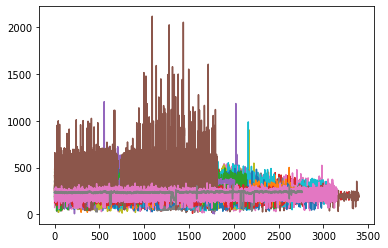

In [87]:
import matplotlib.pyplot as plt

avg_list=[]
for i in range(len(annotations)):
    annotation=open(annotations[i],'r')
    lines=annotation.readlines()
    a_list=[]
    for i in range(3,len(lines)):
        now=list(filter(None,lines[i].split(" ")))[1]
        before=list(filter(None,lines[i-1].split(" ")))[1]
        a_list.append(int(now)-int(before))

    plt.plot(range(0,len(a_list)),a_list)

    a_array=np.array(a_list)
    avg=np.mean(a_array)
    avg_list.append(avg)

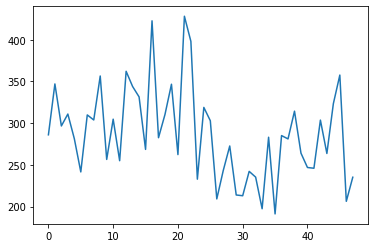

In [88]:
plt.plot(range(0,len(avg_list)),avg_list)

232번 환자가 말썽이기 때문에 제외하고 실시

In [89]:

for i in range(len(records)):
  if records[i].split("/")[-1]=="232.csv":
    records.pop(i)
    annotations.pop(i)
    break

In [97]:
for i in range(len(records)):
    record=pd.read_csv(records[i],index_col=0)
    signals=[]
    try:
        signals.extend(record.loc[:,"'MLII'"].to_list())
    except:
        #메인 리드가 MLII가 아닌 것은 제외한다.
        print(records[i].split('/')[-1]+" 메인 리드 :",end=" ")
        print(record.columns[0])
        continue

    beat=[]
    a=[]
    annotation=open(annotations[i],'r')
    lines=annotation.readlines()
    for j in range(3,len(lines)): # 1번 ~ 2번: 시작 지점이라 이상함
        now_tmp=list(filter(None,lines[j].split(" ")))
        before_tmp=list(filter(None,lines[j-1].split(" ")))
        now_num_sample=int(now_tmp[1])
        before_num_sample=int(before_tmp[1])
        beat_type=now_tmp[2]
        if (beat_type in classes):
            beat_idx=classes.index(beat_type)
            if count_classes[beat_idx] > maximum_counting: #################확인 필요#####################
                continue
            else:
                count_classes[beat_idx]+=1
                beat=signals[before_num_sample:now_num_sample]
                print(len(beat))
                X.append(beat)
                if len(signals[before_num_sample:now_num_sample])>1000:
                    print("심박 1000 이상 찍힘 : ",annotations[i])
                Y.append(beat_idx)

235
188
219
197
193
224
194
212
231
220
225
212
208
216
220
202
228
215
193
198
217
232
207
231
213
214
221
218
194
236
244
215
190
194
333
237
102.csv 메인 리드 : 'V5'
278
262
104.csv 메인 리드 : 'V5'
234
220
204
215
226
191
75
179
182
171
284
287
258
273
211
178
180
211
227
234
225
236
228
247
239
215
223
235
238
231
222
213
235
233
232
204
235
190
189
258
227
213
189
181
191
195
199
191
197
195
217
201
222
206
198
228
227
220
190
207
222
233
215
224
222
215
217
213
217
228
215
222
230
228
242
221
215
210
221
241
235
229
206
242
238
229
226
235
226
226
221
223
222
228
230
218
292
215
231
234
189
198
191
194
186
188
178
192
195
195
224
201
192
203
252
346
256
199
190
189
205
213
234
187
213
229
217
207
184
204
221
201
217
203
210
205
233
227
212
203
224
225
211
199
215
231
230
222
199
176
183
170
186
162
205
200
155
231
208
157
119
152
258
165
209
231
140
138
166
192
145
187
139
177
129
186
201
271
178
143
206
177
171
183
171
174
176
183
171
179
180
174
179
185
181
190
149
177
185
161
188
154

In [91]:
print(len(X))
print(len(Y))

53500
53500


#### 각각의 비트마다 포함된 포인트 수가 차이 남

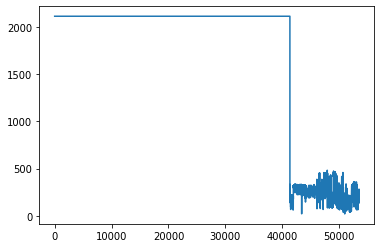

In [92]:
X_len=[len(x) for x in X]
plt.plot(range(0,len(X_len)),X_len)

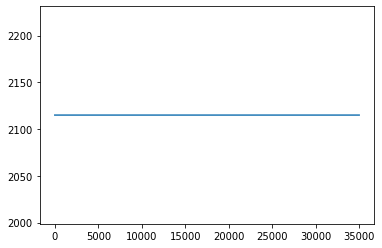

In [93]:
plt.plot(range(0,len(X_len[:35000])),X_len[:35000])

## 3-2. Data shape

#### 한 비트당 포인트 수를 같게 만들어 줌

In [94]:
maximum=max([len(x) for x in X])
print(maximum)
for x in X:
    if len(x) < maximum:
        x.extend([0]*(maximum-len(x)))

2115


아래 그림을 보면, 비트 길이가 2000가까이 되는 것은 타겟 비트에 포함되지 않는다. 

(53500, 2115) (53500,)
N
V
A
R
/
L
(53500, 2115)


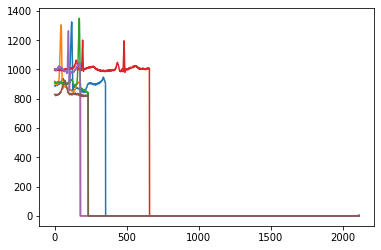

In [95]:
print(np.shape(X),np.shape(Y))
tmp=[]
for i in range(len(X)):
    if Y[i] not in tmp:
        tmp.append(Y[i])
        plt.plot(X[i])
        print(classes[Y[i]])
print(np.shape(X))

In [96]:
# X 배열 끝에 Y값 삽입
for i in range(len(X)):
    X[i].append(Y[i])

In [76]:
X_train_df = pd.DataFrame(X)
#각각의 beat type의 count
per_class=X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class) #V5 포함했을 때와 비교했을 때 '5'의 카운트가 크게 차이남

0    10001
1     8072
2     7253
5     7024
4     6668
3     2331
Name: 2114, dtype: int64


## 1-4. Resampling

(확인 필요)

### 5000 이상 : 중복 X   // 5000 이하 : 중복 O

In [77]:
from sklearn.utils import resample
resampled_X_train_df=pd.DataFrame()
for name, group in X_train_df.groupby(X_train_df[X_train_df.shape[1]-1]):
    if len(group)>5000:
        tmp=resample(group,replace=False,n_samples=5000, random_state=880818)
    else:
        tmp=resample(group,replace=True, n_samples=5000, random_state=880818)
    print(len(tmp))
    resampled_X_train_df=pd.concat([resampled_X_train_df,tmp])
print(len(resampled_X_train_df))
resampled_X_train_df

5000
5000
5000
5000
5000
5000
30000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2113,2114
6427,928,928,929,926,927,923,922,923,923,926,927,929,927,925,924,922,919,915,916,916,916,917,918,918,916,914,913,912,909,905,907,904,903,905,906,907,907,904,903,902,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12705,976,972,966,966,968,971,973,970,965,967,965,969,968,966,967,969,969,971,971,971,965,969,968,973,975,973,973,971,973,974,976,974,972,970,970,975,978,976,974,972,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7067,935,936,937,933,932,933,931,931,930,929,929,928,934,937,936,937,937,936,939,942,946,946,949,951,953,955,954,952,947,940,938,933,931,926,923,920,919,919,918,916,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7068,909,909,914,911,916,918,919,919,918,917,917,914,916,918,921,922,925,928,926,924,924,927,925,922,926,928,932,936,940,939,942,942,939,939,939,939,941,943,943,944,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6154,904,906,908,910,913,916,915,908,902,897,893,893,895,895,898,900,900,901,896,894,889,886,886,884,885,887,887,890,892,897,901,906,914,933,962,1015,1086,1174,1258,1321,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30775,1136,1123,1111,1102,1090,1075,1061,1047,1040,1032,1026,1017,1007,999,994,995,991,986,981,974,976,976,976,974,971,968,970,973,970,967,966,965,966,971,967,966,963,964,965,967,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
19898,1055,1055,1053,1053,1055,1054,1056,1060,1063,1062,1064,1064,1065,1063,1060,1061,1059,1055,1054,1053,1052,1049,1046,1046,1046,1047,1048,1048,1049,1050,1049,1053,1049,1046,1043,1041,1042,1051,1064,1083,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
20418,829,830,833,831,836,837,840,841,842,844,846,849,853,857,863,868,873,875,880,882,884,884,886,889,892,895,898,903,905,908,909,909,911,908,905,904,910,908,910,911,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
27089,936,940,939,939,939,936,936,937,939,938,936,936,939,939,938,937,937,933,937,939,940,938,937,935,935,937,937,937,937,936,935,937,939,935,934,933,934,936,937,937,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


# 2. Modeling

## 2-1. Set 분할

In [78]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [79]:
train, test=train_test_split(resampled_X_train_df,test_size=0.30)
print("X_train : ",len(train))
print("X_test : ",len(test))

X_train :  21000
X_test :  9000


In [80]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
print("Y shape :",np.shape(y_train),np.shape(y_test))

x_train=train.iloc[:,:train.shape[1]-1].values
x_test=test.iloc[:,:test.shape[1]-1].values
x_train=x_train.reshape(len(x_train),x_train.shape[1],1)
x_test=x_test.reshape(len(x_test),x_test.shape[1],1)
print("X shape :",np.shape(x_train),np.shape(x_test))

Y shape : (21000, 6) (9000, 6)
X shape : (21000, 2114, 1) (9000, 2114, 1)


## 2-2. modeling

In [81]:
from keras.layers import Input, Convolution1D, MaxPool1D, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix

In [82]:
def get_model():
    nclass = len(classes)
    inp = Input(x_train.shape[1],1)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

model = get_model()
file_path = "best_model2.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model.fit(x_train, y_train, epochs=1000, verbose=2, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

pred_test = model.predict(x_test)
pred_test = np.argmax(pred_test, axis=-1)

f1 = f1_score(y_test, pred_test, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test, pred_test)

print("Test accuracy score : %s "% acc)

NameError: ignored

In [ ]:
model, history=network(x_train,y_train,x_test,y_test)